In [7]:
import kagglehub
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from cv2.typing import MatLike
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from google.colab import drive
import glob

In [6]:
#---------------------------#
# Constantes                #
#---------------------------#
DRIVE_BASE_PATH = '/content/drive'
DRIVE_FOLDER_PATH = f'{DRIVE_BASE_PATH}/Shareddrives/Processamento de Imagens e Visão Computacional 2025'
RANDOM_SEED = 123
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 25
PADDING = 8

#---------------------------#
# Funções úteis             #
#---------------------------#
def log_warn(message: str):
  print(f"⚠️ \033[33m{message}\033[0m")

def log_error(message: str):
  print(f"❌ \033[31m{message}\033[0m")

def log_success(message: str):
  print(f"✅ \033[32m{message}\033[0m")

def log_info(message: str):
  print(f"ℹ️ \033[34m{message}\033[0m")

def plot_img_samples(images: list[MatLike], title, cmap='gray', nrows=3, ncols=10, figsize=(15, 5)):
    '''
    Exibe uma amostra das imagens fornecidas.
    '''
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.ravel()

    fig.suptitle(title, fontsize=14, weight='bold')

    for i in range(nrows * ncols):
        axes[i].imshow(images[i], cmap=cmap)
        axes[i].axis('off')

    plt.tight_layout(pad=0.25)
    plt.show()

#---------------------------#
# Inicializações            #
#---------------------------#
plt.style.use('dark_background')
drive.mount(DRIVE_BASE_PATH)

if os.path.isdir(DRIVE_FOLDER_PATH):
  log_success('Google Drive inicializado com sucesso!')
else:
  log_error('Erro ao inicializar Google Drive: Pasta compartilhada não encontrada')
  exit(1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive inicializado com sucesso!


In [8]:
# Baixa as imagens de treinamento do Kaggle
base_path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

# Encontra as imagens de cada caso
yes_image_paths = glob.glob(os.path.join(base_path, "yes", "*.jpg"))
no_image_paths = glob.glob(os.path.join(base_path, "no", "*.jpg"))

log_info(f"Imagens positivas: {len(yes_image_paths)}")
log_info(f"Imagens negativas: {len(no_image_paths)}")

Using Colab cache for faster access to the 'brain-mri-images-for-brain-tumor-detection' dataset.
ℹ️ Imagens positivas: 86
ℹ️ Imagens negativas: 85


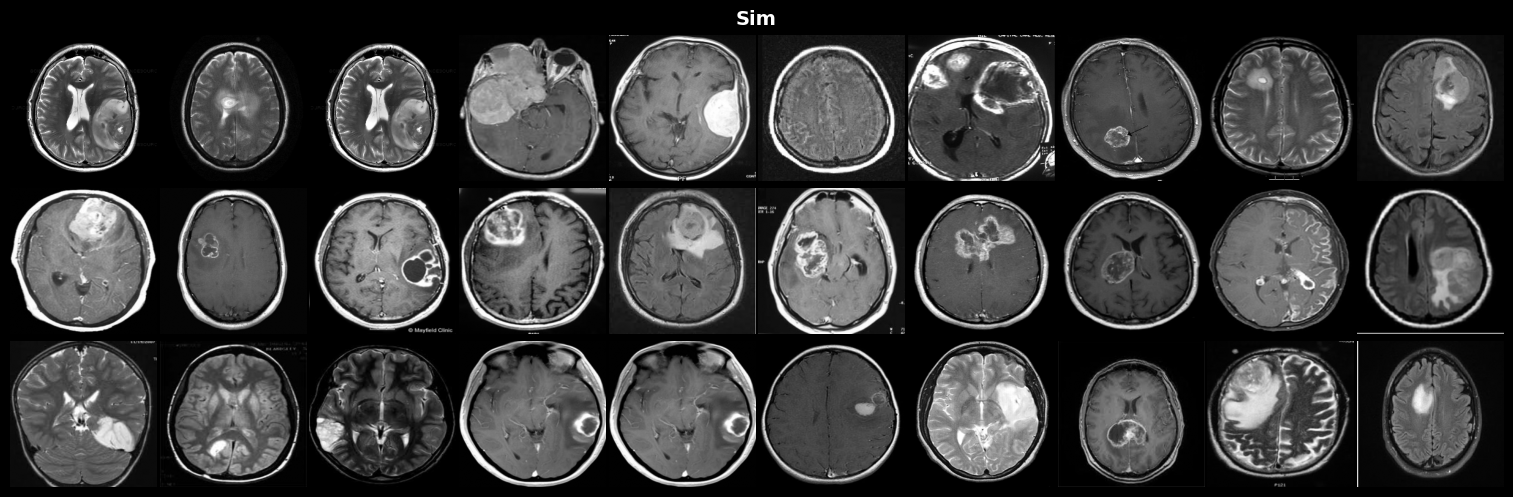

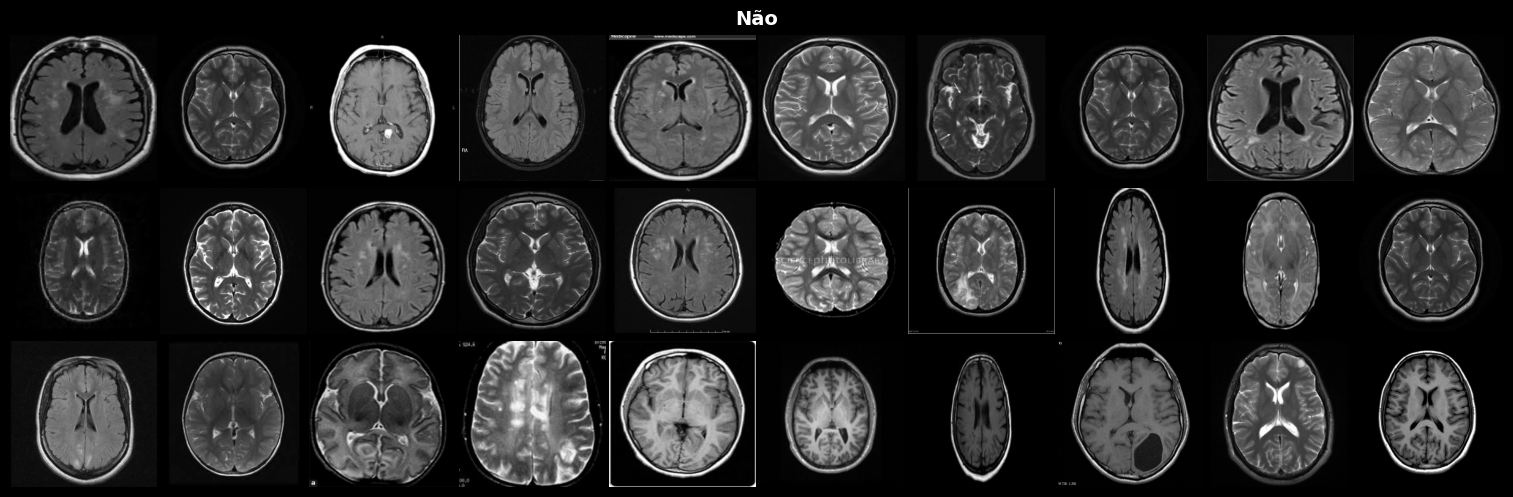

In [9]:
# Carrega as imagens em escala de cinza usando OpenCV
def load_img(path: str):
  if (not os.path.exists(path)):
    log_error(f"A imagem '{path}' não existe.")
    exit(1)

  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

  if img is None:
    log_error(f"Não foi possível carregar a imagem '{path}'.")
    exit(1)

  img = cv2.resize(img, (IMAGE_SIZE + (PADDING * 2), IMAGE_SIZE + (PADDING * 2)))
  return img

yes_images = [load_img(path) for path in yes_image_paths]
no_images = [load_img(path) for path in no_image_paths]

plot_img_samples(yes_images, 'Sim')
plot_img_samples(no_images, 'Não')

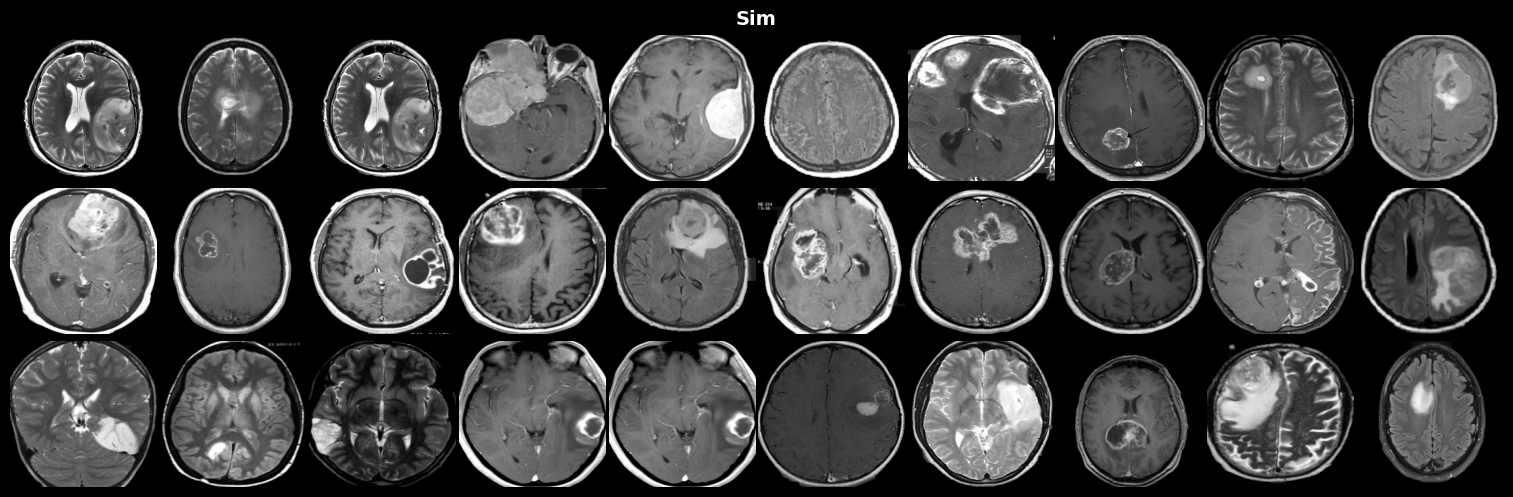

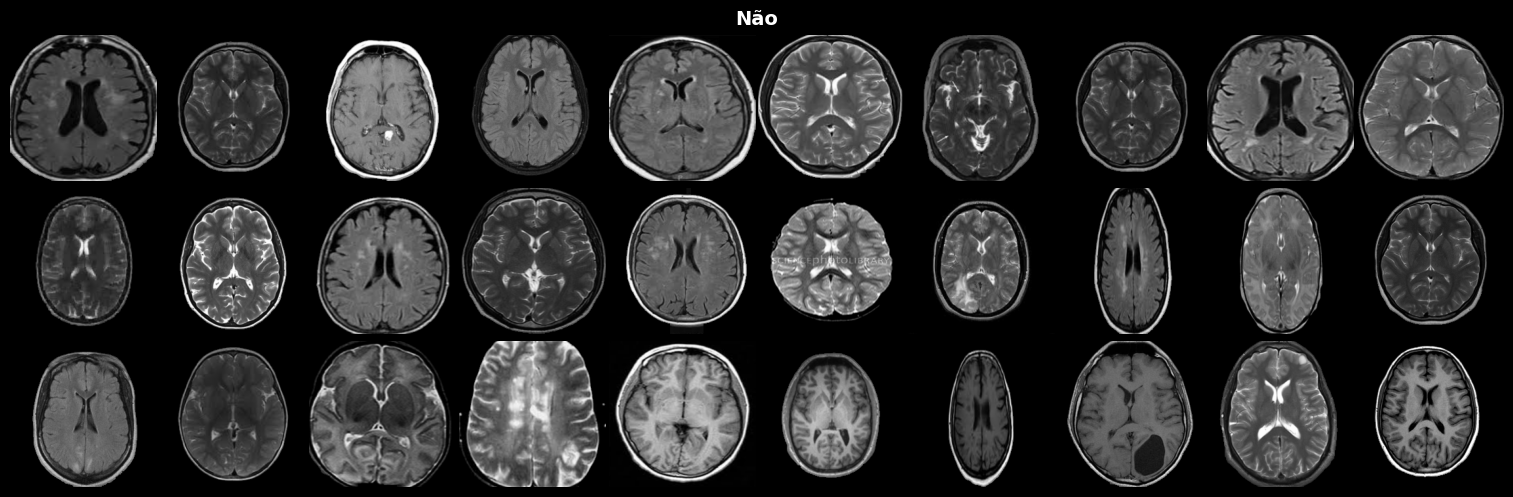

In [10]:
# Prepara as imagens para o modelo
def normalize_background(img: MatLike):
  region_size = 20
  h, w = img.shape

  # Pega as 4 regiões de canto
  corner_tl = img[0:region_size, 0:region_size]
  corner_tr = img[0:region_size, (w - region_size):w]
  corner_bl = img[(h - region_size):h, 0:region_size]
  corner_br = img[(h - region_size):h, (w - region_size):w]

  # Concatena todas as regiões e calcula a média de brilho
  corner_mean = np.mean([corner_tl, corner_tr, corner_bl, corner_br])

  # Se os cantos são brilhantes, inverta a imagem
  if corner_mean > 128: # 128 é um valor de corte (metade de 255)
      return cv2.bitwise_not(img)
  else:
      return img

def remove_dark_background(img: MatLike):
  h, w = img.shape
  img_smooth = cv2.GaussianBlur(img, (5, 5), 0)
  # Detecção de Bordas (Canny)
  borders = cv2.Canny(img_smooth, 50, 150)

  # Conectar as Bordas
  kernel = np.ones((7, 7), np.uint8)
  borders = cv2.morphologyEx(borders, cv2.MORPH_CLOSE, kernel, iterations=3)

  # Encontrar Contornos
  contours, _ = cv2.findContours(borders, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if contours:
      largest_countour = max(contours, key=cv2.contourArea)
      mask = np.zeros_like(img, dtype=np.uint8)
      cv2.drawContours(mask, [largest_countour], -1, (255), thickness=cv2.FILLED)

      # Aplicar a máscara na imagem original para obter o cérebro isolado
      masked_img = cv2.bitwise_and(img, img, mask=mask)

      # Remove pequena parte das bordas da imagem para remover possíveis quadros brancos
      padding = 8
      masked_img = masked_img[padding:h-padding, padding:w-padding]
      return cv2.resize(masked_img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
  else:
      return img

def preprocess_img(img: MatLike):
  img = normalize_background(img)
  img = remove_dark_background(img)
  # Converte de volta para o formato RGB que o modelo aceita
  return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

yes_images_normalized = [preprocess_img(img) for img in yes_images]
no_images_normalized = [preprocess_img(img) for img in no_images]

plot_img_samples(yes_images_normalized, 'Sim')
plot_img_samples(no_images_normalized, 'Não')

ℹ️ Tamanho do treino: 136 imagens
ℹ️ Tamanho da validação: 35 imagens


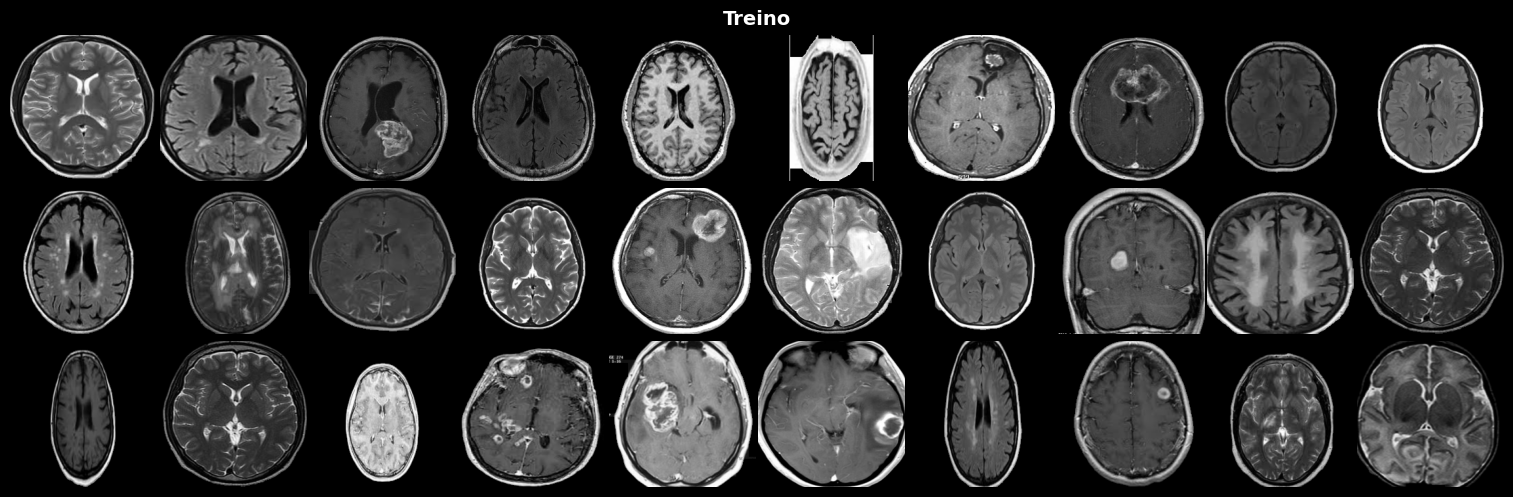

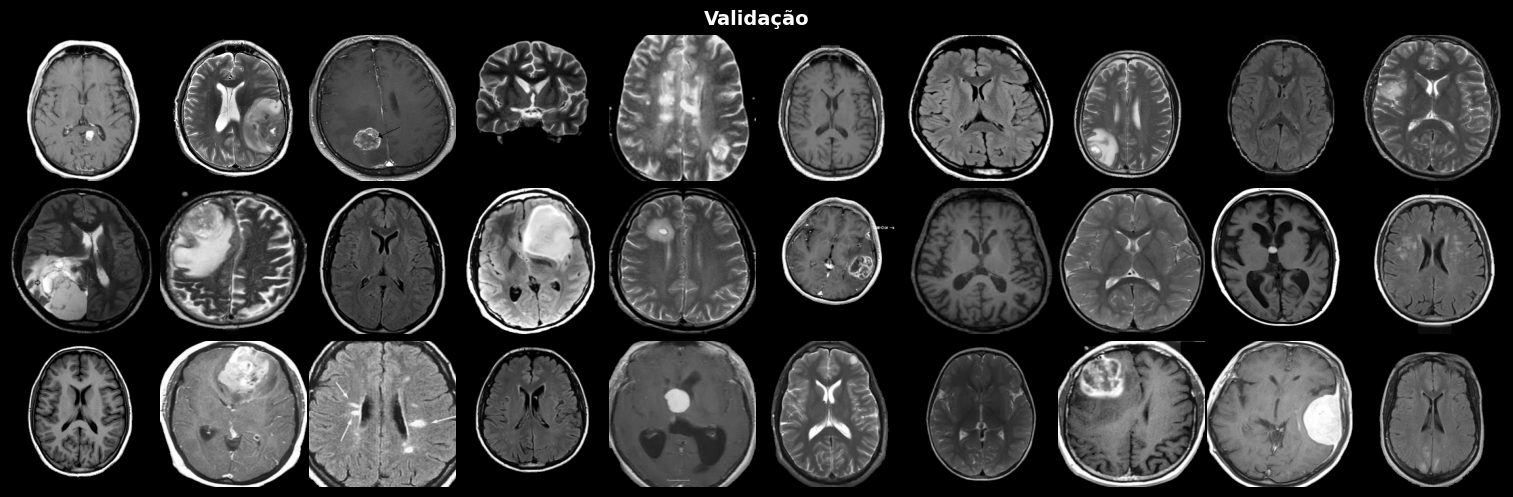

In [11]:
# Divide as imagens em imagens para treinamento e imagens para validação (teste)

# Cria os labels (Rótulos)
# 1 = Sim (Tumor), 0 = Não (Sem Tumor)
yes_labels = np.ones(len(yes_images_normalized))
no_labels = np.zeros(len(no_images_normalized))

# Combina tudo em dois grandes arrays
X = np.array(yes_images_normalized + no_images_normalized)
y = np.array(list(yes_labels) + list(no_labels))

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42, # Para resultados reprodutíveis,
    shuffle=True,
    stratify=y
)

# Vamos aplicar pequenas variações nas imagens de treino
# para o modelo generalizar melhor.
datagen = ImageDataGenerator(
    rotation_range=15,      # Gira a imagem em até 15 graus
    width_shift_range=0.1,  # Move a imagem horizontalmente
    height_shift_range=0.1, # Move a imagem verticalmente
    zoom_range=0.1,         # Aplica zoom
    horizontal_flip=True,   # Inverte a imagem horizontalmente
    fill_mode='nearest'     # Preenche pixels novos
)
# Ajustamos (fit) o datagen APENAS nos dados de treino
datagen.fit(X_train)

log_info(f"Tamanho do treino: {len(X_train)} imagens")
log_info(f"Tamanho da validação: {len(X_val)} imagens")

plot_img_samples(X_train, 'Treino')
plot_img_samples(X_val, 'Validação')

In [12]:
# Modelo otimizado
def create_model():
    base_model = MobileNetV2(
        include_top=False, # Remove a camada final
        weights='imagenet', # Carrega o conhecimento pré-treinado
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )
    base_model.trainable = False

    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    return model

model = create_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# Treinamento
checkpoint_path = f"{DRIVE_FOLDER_PATH}/brain_mri_model_checkpoint.keras"
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

steps_per_epoch = len(X_train) // BATCH_SIZE
validation_data = (X_val, y_val) # Dados de validação (sem augmentation)
validation_steps = len(X_val) // BATCH_SIZE

log_info("=== FASE 1: TREINAMENTO BASE ===")
history1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_data,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

log_success("Treinamento 1 concluído!")

log_info("=== FASE 2: FINE-TUNING ===")
# Descongelar parcialmente a base
for layer in model.layers[1].layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

history2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_data,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

log_success("Treinamento 2 concluído!")

ℹ️ === FASE 1: TREINAMENTO BASE ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.5320 - loss: 0.8208 - precision: 0.4859 - recall: 0.3316
Epoch 1: val_accuracy improved from -inf to 0.65714, saving model to /content/drive/Shareddrives/Processamento de Imagens e Visão Computacional 2025/brain_mri_model_checkpoint.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5322 - loss: 0.8239 - precision: 0.4903 - recall: 0.3532 - val_accuracy: 0.6571 - val_loss: 0.6578 - val_precision: 0.6250 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 2/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.4375 - loss: 0.9490 - precision: 0.5000 - recall: 0.5556

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.65714 to 0.68571, saving model to /content/drive/Shareddrives/Processamento de Imagens e Visão Computacional 2025/brain_mri_model_checkpoint.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.4375 - loss: 0.9490 - precision: 0.5000 - recall: 0.5556 - val_accuracy: 0.6857 - val_loss: 0.6501 - val_precision: 0.6667 - val_recall: 0.7778 - learning_rate: 0.0010
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.6541 - loss: 0.6488 - precision: 0.6490 - recall: 0.5694
Epoch 3: val_accuracy did not improve from 0.68571
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 996ms/step - accuracy: 0.6546 - loss: 0.6491 - precision: 0.6575 - recall: 0.5607 - val_accuracy: 0.6000 - val_loss: 0.6940 - val_precision: 0.6667 - val_recall: 0.4444 - learning_rate: 0.0010
Epoch 4/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6250 - loss: 0.7231 - precision: 0.6667 - recall: 0.6667
Epoch 4: val_accuracy did not improve from 0.68571
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 34

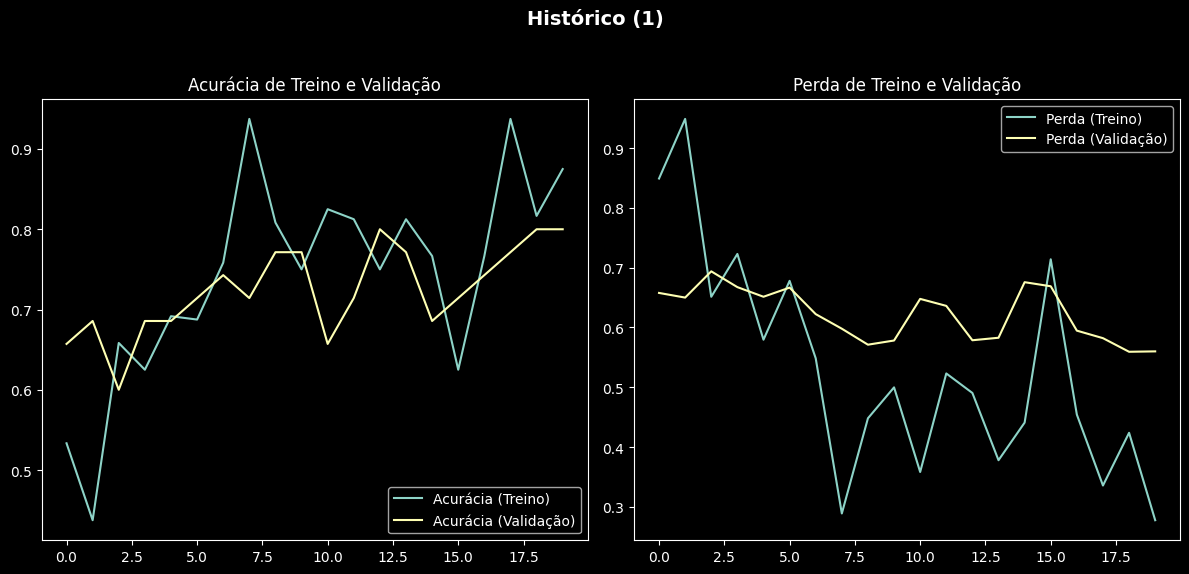

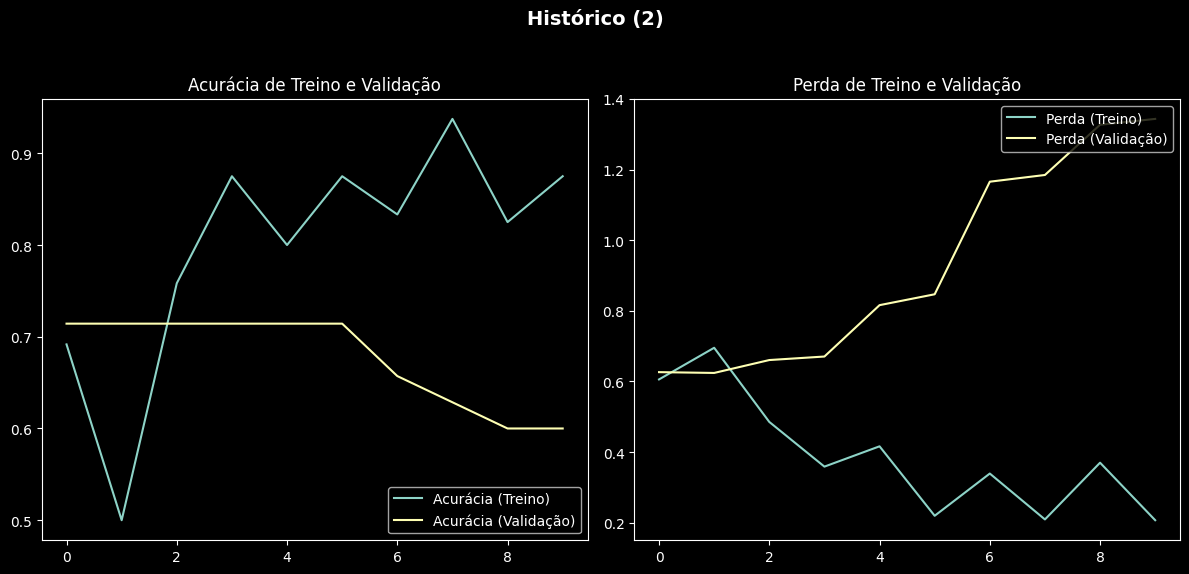

In [18]:
def plotar_resultados(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=14, weight='bold') # Set overall title for the figure

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia (Treino)')
    plt.plot(epochs_range, val_acc, label='Acurácia (Validação)')
    plt.legend(loc='lower right')
    plt.title('Acurácia de Treino e Validação') # Title for the first subplot

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda (Treino)')
    plt.plot(epochs_range, val_loss, label='Perda (Validação)')
    plt.legend(loc='upper right')
    plt.title('Perda de Treino e Validação') # Title for the second subplot

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlapping titles
    plt.show()

plotar_resultados(history1, "Histórico (1)")
plotar_resultados(history2, "Histórico (2)")

In [21]:
# =============================
# 5. Avaliação Final
# =============================
log_info("=== AVALIAÇÃO FINAL ===")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    X_val, y_val,
    steps=len(X_val) // BATCH_SIZE
)

log_info(f"=== RESULTADOS FINAIS ===")
log_info(f"  Accuracy: {test_accuracy:.4f}")
log_info(f"  Precision: {test_precision:.4f}")
log_info(f"  Recall: {test_recall:.4f}")

ℹ️ === AVALIAÇÃO FINAL ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 712ms/step - accuracy: 0.6984 - loss: 0.5704 - precision: 0.6667 - recall: 0.8148
ℹ️ === RESULTADOS FINAIS ===
ℹ️   Accuracy: 0.7143
ℹ️   Precision: 0.6818
ℹ️   Recall: 0.8333


In [22]:
# Salvar modelo final
final_model_path = f"{DRIVE_FOLDER_PATH}/brain_mri_model.keras"
model.save(final_model_path)
log_success(f"Modelo salvo em: {final_model_path}")

✅ Modelo salvo em: /content/drive/Shareddrives/Processamento de Imagens e Visão Computacional 2025/brain_mri_model.keras
